# Generování textu znakovou RNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm

from IPython.core.debugger import set_trace

In [2]:
import torch
import torch.nn.functional as F
from torch import nn

In [3]:
import ans

%load_ext autoreload
%autoreload 2

V tomto cvičení nebudeme používat GPU, protože budeme zpracovávat znaky po jednom a v takto malých dávkách overhead způsobený neustálými přesuny dat mezi GPU a RAM výpočty pouze zpomalí.

# Data

Namísto obrazu tentokrát použijeme textová data. Konkrétně se jedná o novinové nadpisy, které se budeme snažit generovat automaticky. Všechna data jsou v jediném souboru, který si stáhněte [odsud](https://1drv.ms/t/s!AotVPA94wWKxoWLULaBqvPXiNS5t) a uložte jako `data/headlines.txt`.

Z textu byly odstraneny hacky, carky a vsechny nestandardni znaky. Neni tedy potreba resit kodovani apod.

In [4]:
data = open('data/headlines.txt').read()
lines = [line.strip() for line in data.split('\n') if line]

Ukázka dat:

In [5]:
for i in range(10):
    print(i, random.choice(lines))

0 na mezinarodni vesmirnou stanici dorazila nova posadka
1 soud s novakem skoncil driv nez zacal vezen narkl obhajce ze mu napadl pritelkyni
2 jeho podoba se sportovni hvezdou je odzbrojujici prinasi mu ale i problemy
3 koruna po vitezstvi macrona vyrazne posilila k euru i dolaru
4 v prazske zoo odchovali dve mladata vzacneho kakadu palmoveho
5 mobilni datovy provoz letos vzroste o polovinu
6 sledovaci software policie pouzila v desitkach pripadu zaznelo ve snemovne
7 schwarzenegger jel na kole po nadrazi policista to vyresil fotkou a domluvou
8 auto vyletlo v praze ze silnice a skoncilo na strese ridic zemrel
9 v jemenu zustava sedm cechu kteri se chteji evakuovat


Sada znaků = náš slovník:

In [6]:
chars = list(sorted(set(data)))
print(len(chars), chars)

38 ['\n', ' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Následující tabulka (`dict`) nám usnadní převod znaku na index.

In [7]:
chr2idx = {c: i for i, c in enumerate(chars)}

Podíváme se na statistické rozložení prvních znaků ve větách.

In [8]:
counts = {c: 0 for c in chars}
for line in lines:
    counts[line[0]] += 1
counts = np.array([counts[c] for c in chars], dtype=np.float)
p0 = counts / counts.sum()

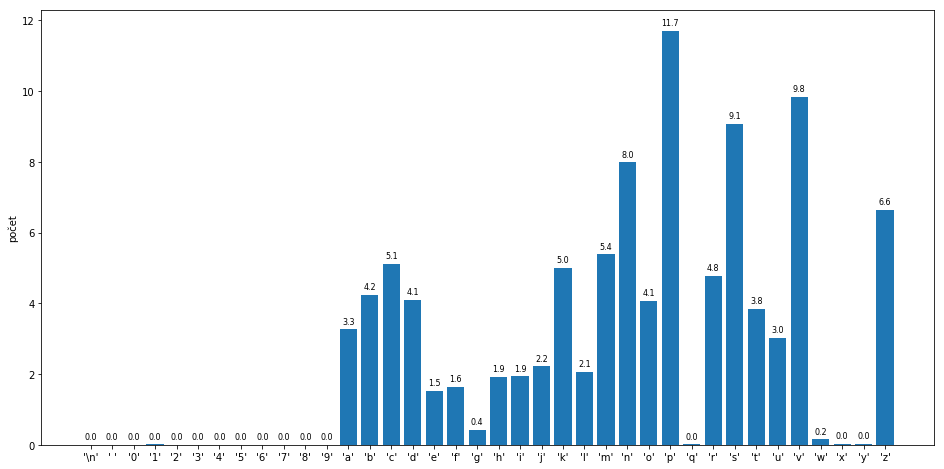

In [9]:
plt.figure(figsize=(16, 8))
rects = plt.bar(range(len(chars)), 100. * p0)
plt.xticks(range(len(chars)), ['{}'.format(repr(c)) for c in chars])
for r in rects:
    x, w, h = r.get_x(), r.get_width(), r.get_height()
    plt.text(x + w / 2., h + 0.1, '{:.1f}'.format(h), ha='center', va='bottom', fontsize=8)
plt.ylabel('počet')
plt.show()

# Sekvenční data a PyTorch

## Embedding

Následující funkce převede řetězec na sekvenci čísel odpovídajících indexům znaků v tabulce. Pokud např. `chars = ['a', 'b', 'c']`, pak řetězec `'acba'` převede na `[0, 2, 1, 0]`. Výsledek vrátí jako PyTorch `Variable`.

In [10]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = chr2idx[string[c]]
    return tensor

In [11]:
x = char_tensor('abca')
x

tensor([12, 13, 14, 12])

Další funkce bude dělat opak: převede sekvenci indexů na řetězec.

In [12]:
def to_string(indices):
    if isinstance(indices, torch.Tensor):
        indices = indices.data
    return ''.join([chars[i] for i in indices])

In [13]:
to_string(x)

'abca'

Sekvenci čísel potřebujeme převést na vektory jednotlivých znaků. Tento proces se v anglické literatuře označuje jako embedding a PyTorch ho implementuje jako vrstvu třídou `Embedding`. Vyjádřením této operace diferencovatelnou vrstvou umožňuje učení vektorů, které tedy nemusejí být fixní. O tom ale až příště.

In [14]:
# velikost slovniku je `len(chars)`
# dimenze znakoveho vektoru bude napr. 30
emb = nn.Embedding(len(chars), 30)

# dopredny pruchod
e = emb(x)
e.shape

torch.Size([4, 30])

In [15]:
e

tensor([[-1.1544e+00, -1.0134e+00, -1.3788e+00,  1.0678e+00, -1.9885e+00,
          8.4640e-01,  1.4523e+00, -8.8704e-02,  1.9542e+00, -1.2148e+00,
         -1.2510e+00,  1.1187e+00, -3.5603e-01,  1.2828e+00, -5.9979e-01,
          1.3035e+00, -1.8070e+00, -9.3445e-01,  5.0911e-01,  1.2028e+00,
          4.5128e-01, -6.1573e-02,  1.7792e+00,  1.2284e+00, -8.0324e-01,
         -5.6158e-01, -7.7137e-01,  1.0307e+00, -7.9248e-01,  1.5412e+00],
        [-1.2831e+00, -7.3999e-01,  9.4584e-01,  5.6494e-01, -3.7515e-01,
          5.4126e-01,  7.0016e-01,  9.3180e-02,  1.2777e-03,  6.6560e-01,
         -1.1467e+00,  1.1126e-01, -1.0164e+00,  6.7574e-01,  6.7863e-02,
         -7.1026e-01, -2.6729e-01, -6.9728e-01, -5.1748e-01, -2.9356e-01,
          4.9190e-01, -7.2783e-01, -1.5866e+00, -5.3186e-01,  5.5840e-02,
          8.7555e-01,  3.1294e-01,  6.4555e-02, -1.3297e-01, -1.1680e+00],
        [ 1.0174e+00, -6.4690e-01,  1.1928e+00,  3.6245e-01, -1.1141e+00,
          1.2496e+00, -2.9565e-01, -

`Embedding` nedělá nic jiného, než že na výstup pro znak s indexem $i$ vrátí $i$-tý řádek své váhové matice `weight`, která drží vektory slov. Defaultně je tato matice inicializována náhodně. Pokud první písmeno v příkladu bylo 'a', jehož index ve "slovníku" `chars` je 12, první řádek embeddingu `e` bude odpovídat 13. řádku (index 12) matice `emb.weight`.

In [16]:
bool(torch.all(e[0] == emb.weight[12]))

True

## RNN v PyTorch

PyTorch implementuje tři z nejrozšířenějších typů sítí třídami `RNN`, `LSTM` a `GRU`. API je pro všechny stejné: dopředný průchod `forward` očekává "zespodu" nějaký vstup `input` a "zleva" minulý stav `h0`. U `LSTM` je tento stav dvouvektorový. Výstupem je `output`, což je vlastně sekvence skrytých stavů poslední vrstvy rekurentní sítě pro jednotlivé kroky v čase, a nový stav `hn` po provedení celého průchodu. Vše vystihuje následující obrázek.

![](https://i.stack.imgur.com/SjnTl.png)

Zdroj: https://stackoverflow.com/a/48305882/9418551

V nejjednoušším případě máme pouze jednu vrstvu sítě a jeden krok. Potom `output` a `hn` jsou stejné. `output` tedy **neprochází žádnou lineární vrstvou**, jak by se mohlo na první pohled zdát. Transformaci na skóre/pravděpodobnost jednotlivých znaků tedy musíme provést sami.

**Příklad:** porovnejme `output` a `hidden`.
tensory by měly být tvaru `(seq, batch, dim)`
- `seq` ... jak jdou znaky ve "věte" za sebou
- `batch` ... počet paralelně zpracovávaných sekvencí, nezávisle na sobě
- `dim` ... příznaky na vstupu

Například tedy: `(10, 3, 5)` by znamenalo:
- 3 paralelně zpracovávané
- 10-znakové věty,
- kde každý znak reprezentuje 5dimenzionální vektor

In [17]:
# do site posleme pouze jeden znak
e0 = e[0].reshape(1, 1, -1)
e0.shape

torch.Size([1, 1, 30])

In [18]:
# RNN ocekava na vstupu vektor o rozmeru 6 a skryty stav bude mit rozmer 8
rnn = nn.RNN(30, 8)

# inicializace skryteho stavu a vstupu
# tensory by mely byt tvaru (seq, batch, dim)
h = torch.rand(8)
o, h = rnn(e0)

print(o)
print(h)

tensor([[[-0.5635, -0.7940,  0.9375,  0.1922,  0.9584,  0.9864, -0.7404,
           0.0823]]], grad_fn=<StackBackward>)
tensor([[[-0.5635, -0.7940,  0.9375,  0.1922,  0.9584,  0.9864, -0.7404,
           0.0823]]], grad_fn=<StackBackward>)


Nyní už více samostatně. Zadefinujeme vlastní třídu, která bude řešit jednotlivé kroky sama ve svém dopředném průchodu. Vstupem tedy bude sekvence čísel, výstupem skóre jednotlivých kroků a skrytý stav z posledního kroku.

In [19]:
class RNN(nn.Module):
    def __init__(self, voc_size, emb_dim, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()

        #################################################################
        # ZDE DOPLNIT
        
        self.voc_size = voc_size
        self.emb_dim = emb_dim
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.emb = nn.Embedding(self.voc_size, self.emb_dim)
        self.rnn = nn.LSTM(self.emb_dim, self.hidden_size, num_layers=self.n_layers)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        
        #################################################################

    def forward(self, x, hidden):
        
        #################################################################
        # ZDE DOPLNIT
        
        e = self.emb(x).reshape(1, 1, -1)
        
        out, hidden = self.rnn(e, hidden)
        score = self.fc(out)
        
        #################################################################
        
        return score, hidden

    def init_hidden(self):
        
        #################################################################
        # ZDE DOPLNIT
        # funkce vrati skryty vektor nainicalizovany na nuly
        
        hidden = (torch.zeros(self.n_layers, 1, self.hidden_size), 
                  torch.zeros(self.n_layers, 1, self.hidden_size))
        
        #################################################################
        
        return hidden

In [99]:
#################################################################
# ZDE DOPLNIT

voc_size = len(chars)
emb_dim = 100
hidden_dim = 100
output_dim = voc_size

#################################################################

rnn = RNN(voc_size, emb_dim, hidden_dim, output_dim, n_layers=1)
stats = ans.Stats()

Vytvoříme si také funkci pro samplování z naší sítě. Funkce přijme model `rnn`, nějaký inicializační text `init_text`, příp. i inicializační `hidden`, a vygeneruje text - vrací tedy string.

In [100]:
def sample(rnn, init_text='', hidden=None, maxlen=150, mode='multinomial', temperature=0.6):
    """
    generuje text pomoci modelu `rnn`
    
    vstupy:
        rnn ... rekurentni sit odvozena z `nn.Module`, ktera po zavolani vraci dvojici (vyst_skore, skryta_rep)
        init_text ... inicializacni text, na ktery generovani textu navaze
        hidden ... inicializace skryte reprezentace
        maxlen ... maximalni delka generovaneho textu
        mode ... zpusob vyberu nasledujiciho znaku, viz komentare v kodu
        temperature ... vyhlazeni multinomialniho rozlozeni, viz komentare v kodu
    """
    # vystupni text bude pole (na konci prevedeme zpet na str)
    out_text = list(init_text)
    
    # pokud nezadan, inicializujeme nahodne, dle rozlozeni prvnich znaku
    if not out_text:
        s = np.random.choice(len(chars), p=p0)
        out_text = [chars[s]]
    
    # to same hidden
    if hidden is None:
        hidden = rnn.init_hidden()
        
        # vstup projedeme siti, abychom ziskali aktualni hidden stav
        x = char_tensor(out_text)
        for i in range(len(out_text)):
            score, hidden = rnn(x[i], hidden)
    
    # nasledujici znak je posledni znak prozatimniho vystupu
    x = char_tensor(out_text[-1])
    
    # pravdepodobnosti muzeme pocitat softmaxem
    softmax = nn.Softmax(dim=2)

    while True:
        # dopredny pruchod
        score, hidden = rnn(x, hidden)
        
        # pravdepodobnosti znaku
        p = softmax(score).detach().numpy().squeeze()
        # vyberem index `k` nasleduciho znaku
        if mode == 'multinomial':
            # nasledujici znak bude vybran dle ad hoc multinomialniho rozlozeni
            # parametr `temperature` ... vyssi hodnota znamena nahodnejsi vysledky
            # viz https://github.com/karpathy/char-rnn#sampling
            k = torch.multinomial(score.view(-1).div(temperature).exp(), 1)[0]
        elif mode == 'argmax':
            #################################################################
            # ZDE DOPLNIT
            
            # nasledujici znak bude ten, jehoz pravdepodobnost vysla maximalni
            k = np.argmax(p)
            #################################################################
        elif mode == 'proportional':
            #################################################################
            # ZDE DOPLNIT
            
            # nasl. znak se vybere nahodne, ale s pravdepodobnosti proporcionalni k vystupu softmaxu
            # napr. pokud znak 'x' ma dle softmaxu 84 %, bude s pravdepodobnosti 84 % vybran jako vstup do dalsi iterace
            k = list(p).index(np.random.choice(p, p=p))
            
            #################################################################
        
        #################################################################
        # ZDE DOPLNIT
        
        # zastavit, pokud end-token
        if chars[k] == '\n':
            break
        
        # pridat znak na vystup
        out_text.append(chars[k])
        
        # zastavit, pokud text je moc dlouhy
        if len(out_text) == maxlen:
            break
        
        # pripravit vstupni vektor `x` pro dalsi iteraci
        x = char_tensor(out_text[-1])
        
        #################################################################
    
    return ''.join(out_text)

In [101]:
print(sample(rnn, init_text='prezident', mode='proportional'))

prezidentrqrbx7xlctmnmfcdj5h9bm w4zpnnepwso4gkep f 80ql7muwfu9bsynwd6h2xiqxjrq35bd7n77 0jooaoohh3tr5m2f2b42swr2 b1


# Trénování

V každé iteraci pomocí funkce `char_tensor` vytvoříme trénovací data $x_i$, $y_i$, což budou číselné indexy znaků tak, jak je definuje tabulka `chr2idx`. Budeme trénovat generování znaků, tzn. že požadovaným výstupem $y_i$ (label, target) pro vstup $x_i$ je vždy následující znak $y_i=x_{i+1}$. Vektor `y_train` je tedy v tomto případě stejného rozměru jako `X_train`. Poslední znak má jako label `\n`, značící konec sekvence.

Vyzkoušejte si na příkladu:

In [102]:
line = random.choice(lines)
print(line)

behem koncertu v kazachstanu dirigoval skladbu ze star wars sam darth vader


In [103]:
#################################################################
# ZDE DOPLNIT

x = [chr2idx[ch] for ch in line]
y = x[1:] + [chr2idx['\n']]

#################################################################

In [104]:
print('data:   {} ... {}'.format(to_string(x[:10]), to_string(x[-10:])))
print('label:  {} ... {}'.format(to_string(y[:10]), to_string(y[-10:])))

data:   behem konc ... arth vader
label:  ehem konce ... rth vader



In [118]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [119]:
example = sample(rnn, mode='multinomial')
max_per_epoch = 1000

for epoch in range(10):
    # data budou nahodne prehazena
    train_ids = np.random.permutation(len(lines))[:max_per_epoch]

    # progressbar
    pb = tqdm.tqdm_notebook(train_ids, desc='ep {:03d}'.format(epoch))
    
    stats.new_epoch()
    
    for it, idx in enumerate(pb):
        hidden = rnn.init_hidden()
        rnn.zero_grad()
        loss = 0.
    
        #################################################################
        # ZDE DOPLNIT
        
        x = [chr2idx[ch] for ch in lines[idx]]
        y = x[1:] + [chr2idx['\n']]
        
        for ic, c in enumerate(lines[idx]):
            # dopredny pruchod pro `ic`-ty znak
            score, hidden = rnn(torch.tensor(x[ic]), hidden)
            loss += criterion(torch.squeeze(score, 0), torch.tensor([y[ic]]))
        
        loss /= len(x)
        
        #################################################################

        loss.backward()
        optimizer.step()
        
        if it % 100 == 0:
            example = sample(rnn)
        
        stats.append_batch_stats('train', loss=float(loss))
        pb.set_postfix(loss='{:.3f}'.format(stats.ravg('train', 'loss')), ex=example[:40])
    
# pripadne ulozit model
torch.save(rnn.state_dict(), f'lstm-{epoch:02d}.pth')

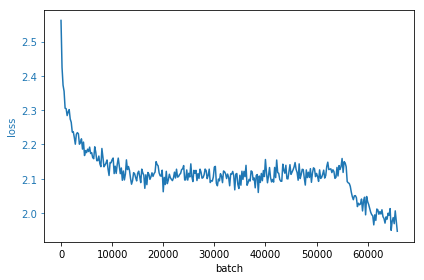

In [121]:
stats.plot_by_batch(block_len=200, right_metric=None)

In [125]:
for i in range(5):
    print(sample(rnn, init_text='prezident', mode='multinomial', temperature=0.5))

prezidentu v za roku na banka v milionu
prezident vyrazi chlami slovensky o prohlasti do nemci krajiny stove ve bilove pres a prohlasti pojemny soudu se se pred vysledni na dalsi vypelem pro
prezidenta mel pribrani miliardy proti na se strelili se kupale ministra vyplati pro nejako zacal mentatne v krupovat prazil ze proti ma vypel nez v m
prezidentu
prezident ze stat usa varku za na horicky na zapluje priji teste si ministan tramskeho se zakladane ssrovani zaleby ukrajine zabola bilova za vyslavi 
